In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # must be installed on your system
    "mathtext.fontset": "cm",             # Computer Modern math, matches LaTeX style
    "text.usetex": True                    # render text via LaTeX
})

In [2]:
# ----------------------------------------------------
# PHYSICAL CONSTANTS (SI Units)
# ----------------------------------------------------
q = 1.602176634e-19         # Elementary charge (C)
k = 1.380649e-23            # Boltzmann constant (J/K)
h = 6.62607015e-34          # Planck constant (J*s)
epsilon_0 = 8.8541878128e-12 # Permittivity of free space (F/m)
m_0 = 9.1093837015e-31      # Free electron rest mass (kg)

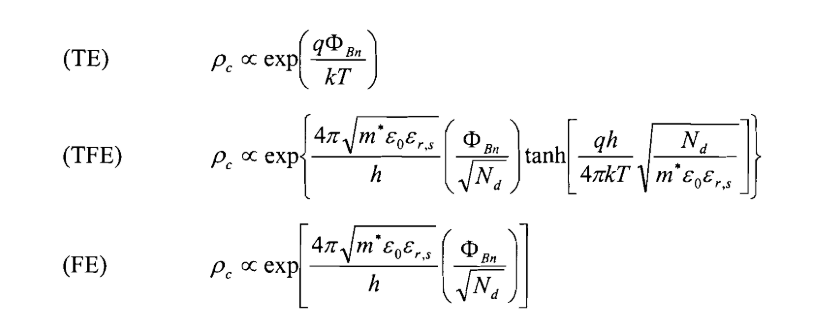

$\rho_{FE} = \frac{k_B sin(c_1k_BT)}{\pi qTA^*} \cdot \exp{\left\{ \frac{q\Phi_B}{E_{00}} \right\}}\\
\text{with} \quad c_1 = \frac{1}{2E_{00}} \cdot \ln{\left( \frac{4(\Phi_B)}{\Phi_n} \right)} $

$\rho_{TFE} = \frac{k_B\sqrt{E_{00}} \cosh{\left(\frac{E_{00}}{k_BT}\right)} \coth{\left(\frac{E_{00}}{k_BT}\right)}}{qTA^* \sqrt{\pi q (\Phi_B-\Phi_n)}} \cdot \exp{\left\{ \frac{q(\Phi_B-\Phi_n)}{E_{00} \coth{\left(\frac{E_{00}}{k_BT}\right)}} + \frac{q\Phi_n}{k_BT}\right\}}$

$\rho_{TE} = \frac{k}{qA^*T} \exp{\left\{ \frac{q\Phi_B}{kT} \right\}}$

In [3]:
def calculate_contact_resistivity(
    N_D_plus_cm3: float,
    Phi_B: float,
    T: float = 300.0,
    Nc_cm3: float = 1.7e19,
    epsilon_s: float = 9.7,
    m_star_ratio: float = 0.37,
    A_star_factor: float = 146.0
) -> float:  
    # ----------------------------------------------------
    # 1. INPUT UNIT CONVERSIONS (cm^-3 to m^-3)
    # ----------------------------------------------------
    conversion_factor = 1e6 # 1 m^3 = 10^6 cm^3
    N_D_plus = N_D_plus_cm3 * conversion_factor
    Nc = Nc_cm3 * conversion_factor
    
    # ----------------------------------------------------
    # 2. CALCULATE MATERIAL-DEPENDENT CONSTANTS (SI)
    # ----------------------------------------------------
    m_star = m_star_ratio * m_0 # Effective mass (kg)
    
    # Richardson constant in SI units (A/m^2/K^2). A* factor is in A/cm^2/K^2, so *1e4.
    A_star = A_star_factor * 1e4 
    
    # Total permittivity
    epsilon = epsilon_s * epsilon_0 

    # ----------------------------------------------------
    # 3. CALCULATE Phi_n (Fermi Level Barrier, in Volts)
    #    Phi_n = -(k/q) * T * ln(N/Nc)
    # ----------------------------------------------------
    thermal_voltage = k / q * T
    
    # Guard against non-physical input where N > Nc (degenerate case requires a different formula)
    if N_D_plus >= Nc:
        # In the degenerate case, the formula for Phi_n given by the user is invalid.
        # We will set a small value for the calculation to proceed, but warn the user.
        print(f"Warning: N_D+ ({N_D_plus_cm3} cm^-3) is >= Nc. Using a modified ratio for non-degenerate Phi_n calculation.")
        phi_n = -thermal_voltage * np.log(0.99) # Use a value slightly less than 1
    else:
        phi_n = -thermal_voltage * np.log(N_D_plus / Nc)
    
    # Ensure phi_n is positive for the log argument in c1, as (Ec - Ef)/q is positive for n-type non-degenerate
    # The user's formula definition for phi_n already contains the negative sign. 
    # For the ratio in c1, we need the magnitude (Ec-Ef)/q, which is the magnitude of phi_n.
    Phi_n_mag = abs(phi_n)

    # ----------------------------------------------------
    # 4. CALCULATE E_00 (Characteristic Energy, in Joules)
    #    E_00 = (q * h / 4pi) * sqrt(N_D+ / (eps_s * eps_0 * m*))
    # ----------------------------------------------------
    prefactor = (q * h) / (4 * np.pi)
    sqrt_term = np.sqrt(N_D_plus / (epsilon * m_star))
    E_00 = prefactor * sqrt_term
    
    # ----------------------------------------------------
    # 5. CALCULATE c_1 (Dimensionless argument helper)
    #    c_1 = (1 / 2 E_00) * log(4 * Phi_B / Phi_n)
    # ----------------------------------------------------
    # The argument log(4*Phi_B / Phi_n) is unitless (V/V). 
    # The term 1 / (2 * E_00) must have units of J^-1 for pi * c1 * k * T to be unitless.
    if Phi_n_mag <= 0:
         print("Error: Calculated Phi_n magnitude is non-positive. Cannot calculate c1.")
         return np.nan

    c1 = (1 / (2 * E_00)) * np.log(4 * Phi_B / Phi_n_mag)
    
    # ----------------------------------------------------
    # 6. CALCULATE rho_K (Contact Resistivity, in Ohm*m^2)
    #    rho_K = (k * sin(pi * c1 * k * T) / (pi * q * A* * T)) * exp(q * Phi_B / E_00)
    # ----------------------------------------------------
    
    # Term 1: Exponential Term (unitless)
    exp_term = np.exp((q * Phi_B) / E_00)
    # print(exp_term)
    # Term 2: Pre-exponential Term (units Ohm*m^2)
    # The argument for sin is pi * c1 * k * T. Since c1 has units J^-1 and k*T has units J,
    # the argument is unitless, which is correct for a sine function.
    sin_arg = np.pi * c1 * k * T
    
    if np.sin(sin_arg) == 0:
        # Avoid division by zero if A_star or T are 0, though T=0 is non-physical
        if A_star == 0 or T == 0:
             return np.nan
        pre_exp_term = 0
    else:
        pre_exp_term = (k * np.sin(sin_arg)) / (np.pi * q * A_star * T)
    
    rho_K = pre_exp_term * exp_term
    
    return rho_K


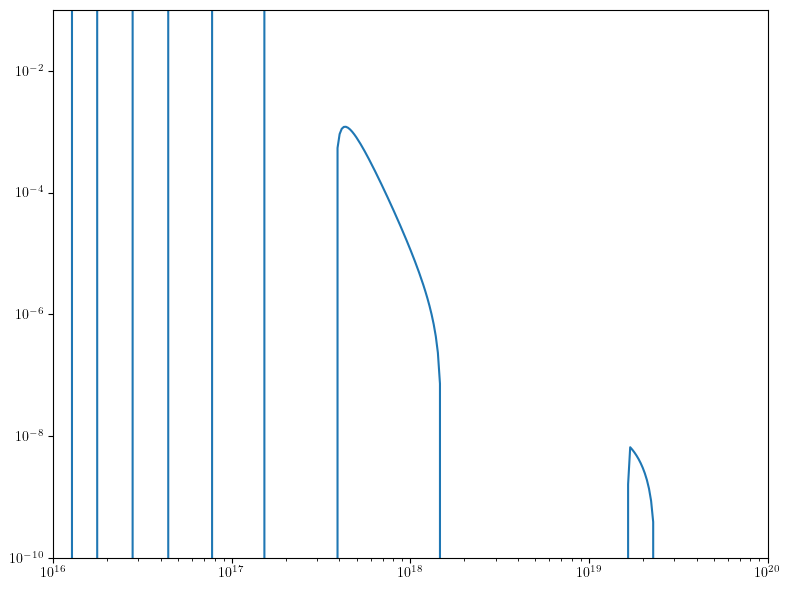

In [4]:

plt.figure(figsize=(8, 6))
N = np.logspace(16, 19.5, 300) 
rho_FE_array = []
for n in N:
    # print(n)
    rho_FE = calculate_contact_resistivity(
        N_D_plus_cm3=n,
        Phi_B=0.1,
        T=300)
    rho_FE_array.extend([rho_FE* 1e4])  # convert to Ohm*cm^2

plt.loglog(N, rho_FE_array)

plt.xlim(1e16, 1e20)
plt.ylim(1e-10, 1e-1)

plt.tight_layout()
plt.show()

=> sin(x)/x create those sigularities when the sin argument is large

In [5]:
# def test_contact_resistivity(
#     N_D_plus_cm3: float,
#     Phi_B: float,
#     T: float = 300.0,
#     Nc_cm3: float = 1.7e19,
#     epsilon_s: float = 9.7,
#     m_star_ratio: float = 0.37,
#     A_star_factor: float = 146.0
# ) -> float:  
#     # ----------------------------------------------------
#     # 1. INPUT UNIT CONVERSIONS (cm^-3 to m^-3)
#     # ----------------------------------------------------
#     conversion_factor = 1e6 # 1 m^3 = 10^6 cm^3
#     N_D_plus = N_D_plus_cm3 * conversion_factor
#     Nc = Nc_cm3 * conversion_factor
    
#     # ----------------------------------------------------
#     # 2. CALCULATE MATERIAL-DEPENDENT CONSTANTS (SI)
#     # ----------------------------------------------------
#     m_star = m_star_ratio * m_0 # Effective mass (kg)
    
#     # Richardson constant in SI units (A/m^2/K^2). A* factor is in A/cm^2/K^2, so *1e4.
#     A_star = A_star_factor * 1e4 
    
#     # Total permittivity
#     epsilon = epsilon_s * epsilon_0 

#     # ----------------------------------------------------
#     # 3. CALCULATE Phi_n (Fermi Level Barrier, in Volts)
#     #    Phi_n = -(k/q) * T * ln(N/Nc)
#     # ----------------------------------------------------
#     thermal_voltage = k / q * T
    
#     # Guard against non-physical input where N > Nc (degenerate case requires a different formula)
#     if N_D_plus >= Nc:
#         # In the degenerate case, the formula for Phi_n given by the user is invalid.
#         # We will set a small value for the calculation to proceed, but warn the user.
#         print(f"Warning: N_D+ ({N_D_plus_cm3} cm^-3) is >= Nc. Using a modified ratio for non-degenerate Phi_n calculation.")
#         phi_n = -thermal_voltage * np.log(0.99) # Use a value slightly less than 1
#     else:
#         phi_n = -thermal_voltage * np.log(N_D_plus / Nc)
    
#     # Ensure phi_n is positive for the log argument in c1, as (Ec - Ef)/q is positive for n-type non-degenerate
#     # The user's formula definition for phi_n already contains the negative sign. 
#     # For the ratio in c1, we need the magnitude (Ec-Ef)/q, which is the magnitude of phi_n.
#     Phi_n_mag = abs(phi_n)

#     # ----------------------------------------------------
#     # 4. CALCULATE E_00 (Characteristic Energy, in Joules)
#     #    E_00 = (q * h / 4pi) * sqrt(N_D+ / (eps_s * eps_0 * m*))
#     # ----------------------------------------------------
#     prefactor = (q * h) / (4 * np.pi)
#     sqrt_term = np.sqrt(N_D_plus / (epsilon * m_star))
#     E_00 = prefactor * sqrt_term
#     # ----------------------------------------------------
#     # 6. CALCULATE rho_c (Contact Resistivity, in Ohm*m^2)
#     #    
#     # ----------------------------------------------------
#     exp_term = np.exp((q * Phi_B) / E_00)
#     rho_FE = ((k*E_00) / (q*A_star*T* np.sqrt(np.pi * E_00 * q*(Phi_B-Phi_n_mag) ))) * exp_term

#     return rho_FE


# plt.figure(figsize=(8, 6))
# N = np.logspace(16, 20, 300) 
# rho_FE_array = []
# for n in N:
#     # print(n)
#     rho_FE = test_contact_resistivity(
#         N_D_plus_cm3=n,
#         Phi_B=0.1,
#         T=300)
#     rho_FE_array.extend([rho_FE* 1e4])  # convert to Ohm*cm^2

# plt.loglog(N, rho_FE_array)

# plt.xlim(1e16, 1e20)
# plt.ylim(1e-10, 1e-1)
# plt.grid(True, which="both", ls="--", linewidth=0.5)

# plt.tight_layout()
# plt.show()

In [6]:
def calculate_contact_resistivity(
    N_D_plus_cm3: float,
    Phi_B: float,
    T: float = 300.0,
    Nc_cm3: float = 1.7e19,
    epsilon_s: float = 9.66,
    m_star_ratio: float = 0.25, # anisotropic -> 0.2 -> 0.4
    A_star_factor: float = 146.0
) -> float:
    """
    Calculates the contact resistivity (rho_c) based on the canonical Field Emission (FE) 
    model, which is dominant in highly doped semiconductors (high N_D+).
    
    Formula used:
    rho_FE = [k/(q A* T)] * sqrt[ (pi * E_00) / (q * (Phi_B - Phi_n)) ] * [1 / cosh(E_00 / (k T))] * exp(q * Phi_B / E_00)

    Parameters:
    - N_D_plus_cm3 (float): Net doping concentration (N_D+) in the semiconductor (cm^-3).
    - Phi_B (float): Schottky barrier height (in Volts).
    - T (float): Temperature (in Kelvin). Default is 300 K (Room Temperature).
    - Nc_cm3 (float): Effective density of states in the conduction band (Nc) (cm^-3). 
    - epsilon_s (float): Relative permittivity (dielectric constant) of the semiconductor. 
    - m_star_ratio (float): Ratio of the effective mass (m*) to the free electron mass (m0). 
    - A_star_factor (float): Richardson constant (A*) in units of A/cm^2/K^2. 

    Returns:
    - rho_K (float): The contact resistivity in Ohm * m^2.
    """
    # ----------------------------------------------------
    # 1. INPUT UNIT CONVERSIONS (cm^-3 to m^-3)
    # ----------------------------------------------------
    conversion_factor = 1e6 # 1 m^3 = 10^6 cm^3
    N_D_plus = N_D_plus_cm3 * conversion_factor
    Nc = Nc_cm3 * conversion_factor
    
    # ----------------------------------------------------
    # 2. CALCULATE MATERIAL-DEPENDENT CONSTANTS (SI)
    # ----------------------------------------------------
    m_star = m_star_ratio * m_0 # Effective mass (kg)
    
    # Richardson constant in SI units (A/m^2/K^2). A* factor is in A/cm^2/K^2, so *1e4.
    A_star = A_star_factor * 1e4 
    
    # Total permittivity
    epsilon = epsilon_s * epsilon_0 

    # ----------------------------------------------------
    # 3. CALCULATE Phi_n (Fermi Level Barrier, in Volts)
    #    Phi_n = -(k/q) * T * ln(N/Nc) 
    # ----------------------------------------------------
    thermal_voltage_V = k / q * T
    
    if N_D_plus >= Nc:
        # For degenerate case, E_c - E_f < 0. Phi_n should be 0 or negative. 
        # For the sqrt(Phi_B - Phi_n) term in the denominator, we approximate Phi_n = 0.
        Phi_n_V = 0.0 
    else:
        phi_n = -thermal_voltage_V * np.log(N_D_plus / Nc)
        # Phi_n (Ec - Ef)/q is positive for non-degenerate n-type.
        Phi_n_V = abs(phi_n)

    # ----------------------------------------------------
    # 4. CALCULATE E_00 (Characteristic Energy, in Joules)
    #    E_00 = (q * h / 4pi) * sqrt(N_D+ / (eps_s * eps_0 * m*))
    # ----------------------------------------------------
    prefactor_E00 = (q * h) / (4 * np.pi)
    sqrt_term = np.sqrt(N_D_plus / (epsilon * m_star))
    E_00 = prefactor_E00 * sqrt_term # E_00 in Joules
    
    if E_00 == 0:
        return np.nan
    
    # Check for non-physical parameters in the square root
    if Phi_B - Phi_n_V <= 0:
        print(f"Warning: Phi_B ({Phi_B} V) <= Phi_n ({Phi_n_V:.2e} V). FE formula invalid for this condition.")
        return np.nan

    # ----------------------------------------------------
    # 5. CALCULATE rho_FE (Field Emission Resistivity, in Ohm*m^2)
    # Formula: rho_FE = [k/(q A* T)] * sqrt[(pi * E_00) / (q * (Phi_B - Phi_n))] * [1 / cosh(E_00 / (k T))] * exp(q * Phi_B / E_00)
    # ----------------------------------------------------
    
    # Term 1: Pre-factor [k / (q A* T)]
    pre_factor = k / (q * A_star * T)
    
    # Term 2: Square Root Term (unitless)
    # (E_00 is in J. q*Phi_B is in J. The ratio is unitless.)
    sqrt_term_fe = np.sqrt((np.pi * E_00) / (q * (Phi_B - Phi_n_V)))
    
    # Term 3: cosh Term (unitless)
    cosh_arg = E_00 / (k * T) # J / J = unitless
    cosh_term = 1.0 / np.cosh(cosh_arg)
    
    # Term 4: Exponential Tunneling Factor (unitless)
    exp_term = np.exp((q * Phi_B) / E_00) # J / J = unitless
    
    rho_FE = pre_factor * cosh_term * exp_term   # sqrt_term_fe does not have a significant influence
    # rho_FE = k/(A_star*T*np.sqrt(E_00)) * cosh_term * exp_term
    
    return rho_FE

# ----------------------------------------------------
# Using the function to plot contact resistivity vs doping concentration
# ----------------------------------------------------
try:
    # Doping concentrations from 1e16 to 1e20 cm^-3 (logarithmic sweep)
    N = np.logspace(16, 20, 300) 
    barrier_height_V_plot = [0.60, 0.50, 0.40, 0.30, 0.25, 0.20]
    temperature_K = 300.0
    
    # Initialize Plot
    plt.figure(figsize=(8, 6))
    

    for phi_B in barrier_height_V_plot:
        print(f"Calculating for Barrier Height: {phi_B} V")

        rho_c_array = []
        for n in N:
            # Calculate resistivity using the canonical FE formula
            rho_TFE = calculate_contact_resistivity(
                N_D_plus_cm3=n,
                Phi_B=phi_B,
                T=temperature_K
            )
            rho_c_cm2 = rho_TFE * 1e4
            rho_c_array.append(rho_c_cm2)
        
        # Prepare data for plotting
        N_clean = np.array(N)
        rho_c_clean = np.array(rho_c_array)

        # Plotting the data
        plt.loglog(N_clean, rho_c_clean, label=f'FE Model ($\\Phi_B={phi_B}$ V)')

    plt.xlabel('Doping Density $N_D^{+}$ $(\\text{cm}^{-3})$')
    plt.ylabel('Contact Resistivity $\\rho_{\\text{FE}}$ $(\\Omega \\cdot \\text{cm}^2)$')
    plt.title('Field Emission Contact Resistivity vs. Doping Density (Canonical FE)')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    
    plt.xlim(1e16, 1e20)
    plt.ylim(1e-10, 1e-0)
    
    plt.legend()
    plt.tight_layout()
    plt.show()

except Exception as e:
    # Simple check for plotting errors
    print(f"An error occurred during plotting: {e}")
    print("\n--- Stable Calculation Check (No Plot) ---")
    doping_cm3_test = 1e19
    contact_res_test = calculate_contact_resistivity(doping_cm3_test, 0.3)
    print(f"Doping: {doping_cm3_test:.2e} cm^-3 -> rho_K: {contact_res_test * 1e4:.2e} Ohm*cm^2")

Calculating for Barrier Height: 0.6 V
Calculating for Barrier Height: 0.5 V
Calculating for Barrier Height: 0.4 V
Calculating for Barrier Height: 0.3 V
Calculating for Barrier Height: 0.25 V
Calculating for Barrier Height: 0.2 V
An error occurred during plotting: latex was not able to process the following string:
b'Doping Density $N_D^{+}$ $(\\\\text{cm}^{-3})$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (MiKTeX 25.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(file.tex
LaTeX2e <2025-06-01> patch level 1
L3 programming layer <2025-10-09>
(C:\Program Files\MiKTeX\tex/latex/base\article.cls
Document Class: article 2025/01/22 v1.4n Standard LaTeX document class
(C:\Program Files\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/cm-

RuntimeError: latex was not able to process the following string:
b'Contact Resistivity $\\\\rho_{\\\\text{FE}}$ $(\\\\Omega \\\\cdot \\\\text{cm}^2)$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (MiKTeX 25.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(file.tex
LaTeX2e <2025-06-01> patch level 1
L3 programming layer <2025-10-09>
(C:\Program Files\MiKTeX\tex/latex/base\article.cls
Document Class: article 2025/01/22 v1.4n Standard LaTeX document class
(C:\Program Files\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Program Files\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Program Files\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Program Files\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Program Files\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Program Files\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/underscore\underscore.sty)
==> First Aid for underscore.sty applied!
(C:\Program Files\MiKTeX\tex/latex/firstaid\underscore-ltx.sty)
(C:\Program Files\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Program Files\MiKTeX\tex/latex/l3backend\l3backend-dvips.def)
No file file.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.30 {\rmfamily Contact Resistivity $\rho_{\text
                                                {FE}}$ $(\Omega \cdot \text{...

No pages of output.
Transcript written on file.log.




RuntimeError: latex was not able to process the following string:
b'Contact Resistivity $\\\\rho_{\\\\text{FE}}$ $(\\\\Omega \\\\cdot \\\\text{cm}^2)$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (MiKTeX 25.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(file.tex
LaTeX2e <2025-06-01> patch level 1
L3 programming layer <2025-10-09>
(C:\Program Files\MiKTeX\tex/latex/base\article.cls
Document Class: article 2025/01/22 v1.4n Standard LaTeX document class
(C:\Program Files\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Program Files\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Program Files\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Program Files\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Program Files\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Program Files\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/underscore\underscore.sty)
==> First Aid for underscore.sty applied!
(C:\Program Files\MiKTeX\tex/latex/firstaid\underscore-ltx.sty)
(C:\Program Files\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Program Files\MiKTeX\tex/latex/l3backend\l3backend-dvips.def)
No file file.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.30 {\rmfamily Contact Resistivity $\rho_{\text
                                                {FE}}$ $(\Omega \cdot \text{...

No pages of output.
Transcript written on file.log.




<Figure size 800x600 with 1 Axes>

$$\rho_{FE} = \left[ \frac{k_B}{q A^* T} \cdot \sqrt{\frac{\pi E_{00}}{q(\Phi_B - \Phi_n)}} \cdot \frac{1}{\cosh\left(\frac{E_{00}}{k_B T}\right)} \right] \cdot \exp\left(\frac{q \Phi_B}{E_{00}}\right)$$
$$\rho_{FE} \propto \frac{1}{A^* T \cdot \sqrt{E_{00}}} \cdot \frac{1}{\cosh\left(\frac{E_{00}}{k_B T}\right)} \cdot \exp\left(\frac{q \Phi_B}{E_{00}}\right)$$

In [7]:
def calculate_contact_resistivity(
    N_D_plus_cm3: float,
    Phi_B: float,
    T: float = 300.0,
    Nc_cm3: float = 1.7e19,
    epsilon_s: float = 9.66,
    m_star_ratio: float = 0.25, # anisotropic -> 0.2 -> 0.4
    A_star_factor: float = 146.0
) -> float:
    # ----------------------------------------------------
    # 1. INPUT UNIT CONVERSIONS (cm^-3 to m^-3)
    # ----------------------------------------------------
    conversion_factor = 1e6 # 1 m^3 = 10^6 cm^3
    N_D_plus = N_D_plus_cm3 * conversion_factor
    Nc = Nc_cm3 * conversion_factor
    # ----------------------------------------------------
    # 2. CALCULATE MATERIAL-DEPENDENT CONSTANTS (SI)
    # ----------------------------------------------------
    m_star = m_star_ratio * m_0 # Effective mass (kg)
    # Richardson constant in SI units (A/m^2/K^2). A* factor is in A/cm^2/K^2, so *1e4.
    A_star = A_star_factor * 1e4 
    # Total permittivity
    epsilon = epsilon_s * epsilon_0 

    # ----------------------------------------------------
    # 3. CALCULATE Phi_n (Fermi Level Barrier, in Volts)
    #    Phi_n = -(k/q) * T * ln(N/Nc) 
    # ----------------------------------------------------
    thermal_voltage_V = k / q * T
    
    if N_D_plus >= Nc:
        # For degenerate case, E_c - E_f < 0. Phi_n should be 0 or negative. 
        # For the sqrt(Phi_B - Phi_n) term in the denominator, we approximate Phi_n = 0.
        Phi_n_V = 0.0 
    else:
        phi_n = -thermal_voltage_V * np.log(N_D_plus / Nc)
        # Phi_n (Ec - Ef)/q is positive for non-degenerate n-type.
        Phi_n_V = abs(phi_n)

    # ----------------------------------------------------
    # 4. CALCULATE E_00 (Characteristic Energy, in Joules)
    #    E_00 = (q * h / 4pi) * sqrt(N_D+ / (eps_s * eps_0 * m*))
    # ----------------------------------------------------
    prefactor_E00 = (q * h) / (4 * np.pi)
    sqrt_term = np.sqrt(N_D_plus / (epsilon * m_star))
    E_00 = prefactor_E00 * sqrt_term # E_00 in Joules
    
    if E_00 == 0:
        return np.nan
    
    # Check for non-physical parameters in the square root
    if Phi_B - Phi_n_V <= 0:
        print(f"Warning: Phi_B ({Phi_B} V) <= Phi_n ({Phi_n_V:.2e} V). FE formula invalid for this condition.")
        return np.nan

    # ----------------------------------------------------
    # 5. CALCULATE rho_FE (Field Emission Resistivity, in Ohm*m^2)
    # Formula: rho_FE = [k/(q A* T)] * sqrt[(pi * E_00) / (q * (Phi_B - Phi_n))] * [1 / cosh(E_00 / (k T))] * exp(q * Phi_B / E_00)
    # ----------------------------------------------------
    
    # Term 1: Pre-factor [k / (q A* T)]
    pre_factor = k / (q * A_star * T)
    
    # Term 2: Square Root Term (unitless)
    # (E_00 is in J. q*Phi_B is in J. The ratio is unitless.)
    sqrt_term_fe = np.sqrt((np.pi * E_00) / (q * (Phi_B - Phi_n_V)))
    
    # Term 3: cosh Term (unitless)
    cosh_arg = E_00 / (k * T) # J / J = unitless
    cosh_term = 1.0 / np.cosh(cosh_arg)
    
    # Term 4: Exponential Tunneling Factor (unitless)
    exp_term = np.exp((q * Phi_B) / E_00) # J / J = unitless
    
    def coth(x):
        return np.cosh(x) / np.sinh(x)

    rho_TFE = pre_factor * sqrt_term_fe*  cosh_term * exp_term   # sqrt_term_fe does not have a significant influence
    # rho_TFE = ((k*np.sqrt(E_00)*np.cosh(E_00/(k*T))*coth(E_00/(k*T)))/(A_star*T*np.sqrt(np.pi * q*(Phi_B - Phi_n_V)))) * np.exp(((Phi_B - Phi_n_V)/(E_00*coth(E_00/(k*T)))) + Phi_n_V/(k*T))
    # print(rho_TFE)
    # rho_TFE = pre_factor * np.exp((q*Phi_B/E_00)  * np.tanh(E_00/k*T))

    # rho_FE = k/(A_star*T*np.sqrt(E_00)) * cosh_term * exp_term
    
    rho_FE = ((h**2 * k)/(4*np.pi*q**2 *phi_B*m_star)) * exp_term

    rho_TE = (k/(q*A_star*T)) * np.exp(q*Phi_B/(k*T))

    rho_total = 1 / (1/rho_TE + 1/rho_FE)   # + 1/rho_FE

    return rho_TFE, rho_FE, rho_total

# ----------------------------------------------------
# Using the function to plot contact resistivity vs doping concentration
# ----------------------------------------------------
try:
    # Doping concentrations from 1e16 to 1e20 cm^-3 (logarithmic sweep)
    N = np.logspace(16, 20, 300) 
    # barrier_height_V_plot = [1.00, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30]
    barrier_height_V_plot = [1.00, 0.70, 0.50, 0.4, 0.30]
    temperature_K = 300.0
    
    # Initialize Plot
    plt.figure(figsize=(8, 6))
    

    for phi_B in barrier_height_V_plot:
        rho_TFE_array = []
        rho_FE_array = []
        rho_total_array = []
        for n in N:
            # Calculate resistivity using the canonical FE formula
            rho_TFE , rho_FE, rho_total= calculate_contact_resistivity(
                N_D_plus_cm3=n,
                Phi_B=phi_B,
                T=temperature_K
            )
            rho_TFE_cm2 = rho_TFE * 1e4
            rho_TFE_array.append(rho_TFE_cm2)
            rho_FE_cm2 = rho_FE * 1e4
            rho_FE_array.append(rho_FE_cm2)

            rho_total_cm2 = rho_total * 1e4
            rho_total_array.append(rho_total_cm2)
        
        # Prepare data for plotting
        N_clean = np.array(N)
        rho_TFE_clean = np.array(rho_TFE_array)
        rho_FE_clean = np.array(rho_FE_array)
        rho_total_clean = np.array(rho_total_array)



        # Plotting the data
        plt.loglog(N_clean, rho_FE_clean, label=f'FE Model ($\\Phi_B={phi_B}$ V)', linestyle='--')
        plt.loglog(N_clean, rho_TFE_clean, label=f'TFE Model ($\\Phi_B={phi_B}$ V)')
        # plt.loglog(N_clean, rho_total_clean, label=f'rho total ($\\Phi_B={phi_B}$ V)', linestyle=':')

    plt.xlabel('Doping Density $N_D^{+}$ $(\\text{cm}^{-3})$')
    plt.ylabel('Contact Resistivity $\\rho_{\\text{FE}}$ $(\\Omega \\cdot \\text{cm}^2)$')
    plt.title('Field Emission Contact Resistivity vs. Doping Density (Canonical FE)')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    
    plt.xlim(1e16, 1e20)
    plt.ylim(1e-10, 1e-0)
    
    plt.legend()
    plt.tight_layout()
    plt.show()

except Exception as e:
    # Simple check for plotting errors
    print(f"An error occurred during plotting: {e}")
    print("\n--- Stable Calculation Check (No Plot) ---")
    doping_cm3_test = 1e19
    contact_res_test = calculate_contact_resistivity(doping_cm3_test, 0.3)
    print(f"Doping: {doping_cm3_test:.2e} cm^-3 -> rho_K: {contact_res_test * 1e4:.2e} Ohm*cm^2")

C:\Users\lhager\AppData\Local\Temp\ipykernel_4520\367176010.py:73: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp((q * Phi_B) / E_00) # J / J = unitless
c:\Users\lhager\AppData\Local\Programs\Python\Python314\Lib\site-packages\matplotlib\scale.py:270: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


An error occurred during plotting: latex was not able to process the following string:
b'Doping Density $N_D^{+}$ $(\\\\text{cm}^{-3})$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (MiKTeX 25.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(file.tex
LaTeX2e <2025-06-01> patch level 1
L3 programming layer <2025-10-09>
(C:\Program Files\MiKTeX\tex/latex/base\article.cls
Document Class: article 2025/01/22 v1.4n Standard LaTeX document class
(C:\Program Files\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Program Files\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Program Files\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Program Files\MiKTeX\tex/latex

TypeError: can't multiply sequence by non-int of type 'float'

Error in callback <function _draw_all_if_interactive at 0x00000287FD7CDF30> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'Contact Resistivity $\\\\rho_{\\\\text{FE}}$ $(\\\\Omega \\\\cdot \\\\text{cm}^2)$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (MiKTeX 25.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(file.tex
LaTeX2e <2025-06-01> patch level 1
L3 programming layer <2025-10-09>
(C:\Program Files\MiKTeX\tex/latex/base\article.cls
Document Class: article 2025/01/22 v1.4n Standard LaTeX document class
(C:\Program Files\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Program Files\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Program Files\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Program Files\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Program Files\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Program Files\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/underscore\underscore.sty)
==> First Aid for underscore.sty applied!
(C:\Program Files\MiKTeX\tex/latex/firstaid\underscore-ltx.sty)
(C:\Program Files\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Program Files\MiKTeX\tex/latex/l3backend\l3backend-dvips.def)
No file file.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.30 {\rmfamily Contact Resistivity $\rho_{\text
                                                {FE}}$ $(\Omega \cdot \text{...

No pages of output.
Transcript written on file.log.




RuntimeError: latex was not able to process the following string:
b'Contact Resistivity $\\\\rho_{\\\\text{FE}}$ $(\\\\Omega \\\\cdot \\\\text{cm}^2)$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (MiKTeX 25.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(file.tex
LaTeX2e <2025-06-01> patch level 1
L3 programming layer <2025-10-09>
(C:\Program Files\MiKTeX\tex/latex/base\article.cls
Document Class: article 2025/01/22 v1.4n Standard LaTeX document class
(C:\Program Files\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Program Files\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Program Files\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Program Files\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Program Files\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Program Files\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\lhager\AppData\Roaming\MiKTeX\tex/latex/underscore\underscore.sty)
==> First Aid for underscore.sty applied!
(C:\Program Files\MiKTeX\tex/latex/firstaid\underscore-ltx.sty)
(C:\Program Files\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Program Files\MiKTeX\tex/latex/l3backend\l3backend-dvips.def)
No file file.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
l.30 {\rmfamily Contact Resistivity $\rho_{\text
                                                {FE}}$ $(\Omega \cdot \text{...

No pages of output.
Transcript written on file.log.




<Figure size 800x600 with 1 Axes>

In [9]:
def TFE_Spera(
    N_D_plus_cm3: float,
    Phi_B: float,
    T: float = 300.0,
    Nc_cm3: float = 1.7e19,
    epsilon_s: float = 9.66,
    m_star_ratio: float = 0.25, # anisotropic -> 0.2 -> 0.4
    A_star_factor: float = 146.0
) -> float:
    # ----------------------------------------------------
    # 1. INPUT UNIT CONVERSIONS (cm^-3 to m^-3)
    # ----------------------------------------------------
    conversion_factor = 1e6 # 1 m^3 = 10^6 cm^3
    N_D_plus = N_D_plus_cm3 * conversion_factor
    Nc = Nc_cm3 * conversion_factor
    # ----------------------------------------------------
    # 2. CALCULATE MATERIAL-DEPENDENT CONSTANTS (SI)
    # ----------------------------------------------------
    m_star = m_star_ratio * m_0 # Effective mass (kg)
    # Richardson constant in SI units (A/m^2/K^2). A* factor is in A/cm^2/K^2, so *1e4.
    A_star = A_star_factor * 1e4 
    # Total permittivity
    epsilon = epsilon_s * epsilon_0 


    # ----------------------------------------------------
    # 3. CALCULATE Phi_n
    #    Phi_n = -(k/q) * T * ln(N/Nc) 
    # ----------------------------------------------------
    Phi_n = -(k/q) * T * np.log(N_D_plus/Nc)
    # print(Phi_n)

    # ----------------------------------------------------
    # 4. CALCULATE E_00 (Characteristic Energy, in Joules)
    #    E_00 = (q * h / 4pi) * sqrt(N_D+ / (eps_s * eps_0 * m*))
    # ----------------------------------------------------
    E_00 = (q * h) / (4 * np.pi) * np.sqrt(N_D_plus / (epsilon * m_star)) # E_00 in Joules


    # ----------------------------------------------------
    # 5. CALCULATE TFE (see Spera 2019)
    # ----------------------------------------------------
    def coth(x):
        return np.cosh(x) / np.sinh(x)

    prefactor = (k * np.sqrt(E_00) * np.cosh(E_00/(k*T)) * coth(E_00/(k*T))) / (A_star*T*q * np.sqrt(np.pi*q*(Phi_B - Phi_n)))

    exponential_arg = (q*(Phi_B-Phi_n))/(E_00 * coth(E_00/(k*T))) + (q*Phi_n)/(k*T)

    rho_TFE = prefactor * np.exp(exponential_arg)


    # ----------------------------------------------------
    # 6. CALCULATE FE (see )
    # ----------------------------------------------------
    # rho_FE = ((h**2 * k)/(4*np.pi*q**2 *phi_B*m_star)) * np.exp((q * Phi_B) / E_00)
    rho_FE = ((k)/(q*A_star*T) * 1/(np.cosh(E_00/(k*T)))) * np.exp((q*Phi_B)/(E_00)) # in thesis
    

    # Term 2: Square Root Term (unitless)
    # (E_00 is in J. q*Phi_B is in J. The ratio is unitless.)
    # sqrt_term_fe = np.sqrt((np.pi * E_00) / (q * (Phi_B - Phi_n_V)))
    # rho_FE = (k/(q*A_star*T)) * 1.0 / (np.cosh(E_00 / (k * T))) * np.exp((q * Phi_B) / E_00) 


    return rho_TFE, rho_FE


In [ ]:
def TFE_Kuckuk(
    N_D_plus_cm3: float,
    Phi_B: float,
    T: float = 300.0,
    Nc_cm3: float = 1.7e19,
    epsilon_s: float = 9.66,
    m_star_ratio: float = 0.25, # anisotropic -> 0.2 -> 0.4
    A_star_factor: float = 146.0
) -> float:
    # ----------------------------------------------------
    # 1. INPUT UNIT CONVERSIONS (cm^-3 to m^-3)
    # ----------------------------------------------------
    conversion_factor = 1e6 # 1 m^3 = 10^6 cm^3
    N_D_plus = N_D_plus_cm3 * conversion_factor
    Nc = Nc_cm3 * conversion_factor
    # ----------------------------------------------------
    # 2. CALCULATE MATERIAL-DEPENDENT CONSTANTS (SI)
    # ----------------------------------------------------
    m_star = m_star_ratio * m_0 # Effective mass (kg)
    # Richardson constant in SI units (A/m^2/K^2). A* factor is in A/cm^2/K^2, so *1e4.
    A_star = A_star_factor * 1e4 
    # Total permittivity
    epsilon = epsilon_s * epsilon_0 


    # ----------------------------------------------------
    # 3. CALCULATE Phi_n
    #    Phi_n = -(k/q) * T * ln(N/Nc) 
    # ----------------------------------------------------
    Phi_n = -(k/q) * T * np.log(N_D_plus/Nc)
    # print(Phi_n)

    # ----------------------------------------------------
    # 4. CALCULATE E_00 (Characteristic Energy, in Joules)
    #    E_00 = (q * h / 4pi) * sqrt(N_D+ / (eps_s * eps_0 * m*))
    # ----------------------------------------------------
    E_00 = (q * h) / (4 * np.pi) * np.sqrt(N_D_plus / (epsilon * m_star)) # E_00 in Joules


    # ----------------------------------------------------
    # 5. CALCULATE TFE (see Spera 2019)
    # ----------------------------------------------------
    def coth(x):
        return np.cosh(x) / np.sinh(x)

    prefactor = k**2 / (q*A_star* np.sqrt(np.pi*(Phi_B-Phi_n)*E_00)) * np.cosh(E_00/(k*T)) * np.sqrt(coth(E_00/(k*T)))

    exponential_arg = (q*(Phi_B-Phi_n))/(E_00) - (q*Phi_n)/(k*T)


    rho_TFE = prefactor * np.exp(exponential_arg)

    # (q*(Phi_B-Phi_n))/(E_00 * coth(E_00/(k*T))) + (q*Phi_n)/(k*T)


    return rho_TFE


In [8]:
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # must be installed on your system
    "mathtext.fontset": "cm",             # Computer Modern math, matches LaTeX style
    "text.usetex": True                    # render text via LaTeX
})

C:\Users\lhager\AppData\Local\Temp\ipykernel_4520\3851409742.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(barrier_height)) # Choose a colormap
C:\Users\lhager\AppData\Local\Temp\ipykernel_4520\2337625034.py:57: RuntimeWarning: overflow encountered in exp
  rho_FE = ((k)/(q*A_star*T) * 1/(np.cosh(E_00/(k*T)))) * np.exp((q*Phi_B)/(E_00)) # in thesis


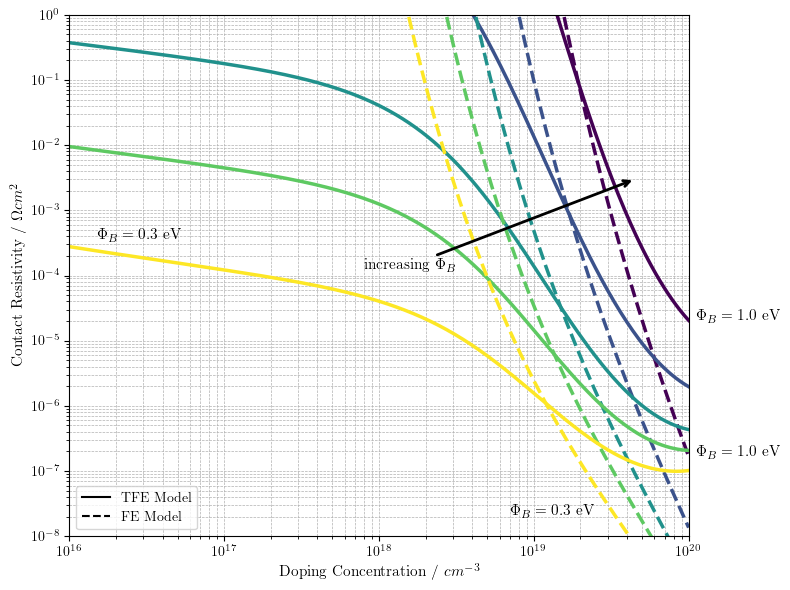

In [16]:

# Doping concentrations from 1e16 to 1e20 cm^-3 (logarithmic sweep)
N = np.logspace(16, 20, 300) 
# barrier_height_V_plot = [1.00, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30]
barrier_height = [1.0, 0.70, 0.50, 0.4, 0.30]
temperature_K = 300.0

# Initialize Plot
plt.figure(figsize=(8, 6))
ax = plt.gca()

# colors = ['orange', 'red', 'purple', 'brown', 'cyan']
colors = plt.cm.get_cmap('viridis', len(barrier_height)) # Choose a colormap

lines_FE = {}
lines_TFE = {}

for i, phi_B in enumerate(barrier_height):
    rho_TFE_array = []
    rho_FE_array = []
    for n in N:
        # Calculate resistivity using the canonical FE formula
        rho_TFE, rho_FE = TFE_Spera(
            N_D_plus_cm3=n,
            Phi_B=phi_B,
            T=temperature_K
        )
        rho_TFE_cm2 = rho_TFE * 1e4
        rho_TFE_array.append(rho_TFE_cm2)

        rho_FE_cm2 = rho_FE * 1e4
        rho_FE_array.append(rho_FE_cm2)

    # Plotting the data
    line_FE, = plt.loglog(
        N, rho_FE_array, 
        label=phi_B,
        linestyle='--',
        color=colors(i),
        linewidth=2.5)
    
    line_TFE, = plt.loglog(
        N, rho_TFE_array,
        label=phi_B,
        color=colors(i),
        linewidth=2.5)

    lines_FE[phi_B] = line_FE
    lines_TFE[phi_B] = line_TFE


# adding annotations
x_label = N[-1]

ax.text(1.5e16, 3.5e-4, '$\\Phi_B=0.3$ eV', fontsize=11, ha='left')
# ax.text(1.5e16, 4.5e-1, '$\\Phi_B=0.5$ eV', fontsize=11, ha='left')
ax.text(7e18, 2.1e-8, '$\\Phi_B=0.3$ eV', fontsize=11, ha='left')
# ax.text(1.5e16, 4.5e-1, '$\\Phi_B=0.5$ eV', fontsize=11, ha='left')
ax.annotate(
    f'$\\Phi_B={1.0}$ eV',
    xy=(x_label, lines_FE[1.0].get_ydata()[-1]),
    xytext=(5, 0),
    textcoords='offset points',
    fontsize=11)
ax.annotate(
    f'$\\Phi_B={1.0}$ eV',
    xy=(x_label, lines_TFE[1.0].get_ydata()[-1]),
    xytext=(5, 0),
    textcoords='offset points',
    fontsize=11)

ax.annotate(
    'increasing $\\Phi_B$',
    xy=(4.5e19, 3e-3),      # Pfeilspitze
    xytext=(8e17, 1.25e-4), # Textstart
    arrowprops=dict(
        arrowstyle='->',
        lw=2
    ),
    fontsize=11,
    rotation=0)


plt.xlabel('Doping Concentration / $cm^{-3}$', fontsize=11)
plt.ylabel('Contact Resistivity / $\\Omega cm^2$', fontsize=11)
# plt.title('TFE Model from Spera 2019')
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.xlim(1e16, 1e20)
plt.ylim(1e-8, 1e-0)


legend_elements = [
    Line2D([0], [0], linestyle='-', color='black', label='TFE Model'),
    Line2D([0], [0], linestyle='--', color='black', label='FE Model'),
]
plt.legend(handles=legend_elements)
# props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# plt.text(0.05, 0.05, f"$m^* = 0.25 m_0$\n$T = 300$ K", 
#          transform=ax.transAxes, verticalalignment='bottom', bbox=props)
plt.tight_layout()
# plt.show()
plt.savefig('../Images/rho_barriers.pdf', dpi=300)